In [1]:
# -*- coding: utf-8 -*-

## Map Generalization for Polygons using Autoencode-like strucutures
## 
## Author: Yu Feng, yuzz.feng@gmail.com
## 1. Version Author: SERCAN CAKIR - Adatped based on Master Thesis of SERCAN CAKIR "ROAD NETWORK EXTRACTION USING CNN"

## Changes:
## 1. Two conv layers were added before the first down convlusional layer
## 2. Output can be any size during the evaluation
## 3. Adapt the code to support more images as training examples
## 4. Dropouot may make the sharpe corners vanishing, we delete half of them, but we should used some
## 5. Splilt step for generate training and validation data
## 6. Prepare to update in github

import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from numpy import random
np.random.seed(7)
import itertools

import keras
from keras import backend as K

from keras.models import Model, Sequential
#from keras.layers.core import Dropout
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate, Add
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

from data_helper import readImg, readImgInv, imagePatches, removeBlackImg, removeCorrespondence, check_and_create

from time import gmtime, strftime
timestr = strftime("%Y-%m-%d %H-%M-%S", gmtime())

scale = 15 #25

############ Path Setting ##############
outPath = r"../tmp_results/predictions/"
outPath = outPath + timestr + '_' + str(scale)+ "/"
check_and_create(outPath)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Prepare Training Data

In [2]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

p_size_1 = 128 # Compared with 256, which larger may generate round corners
trainPath = r"../tmp_data/data_feng/geb" + str(scale) +  "/"

# save image patch arrays
x_train_sim = np.load(trainPath + "x_train_sim.npy")
y_train_sim = np.load(trainPath + "y_train_sim.npy")
x_test_sim = np.load(trainPath + "x_test_sim.npy")
y_test_sim = np.load(trainPath + "y_test_sim.npy")

Input Shape of the models (32289, 128, 128, 1)


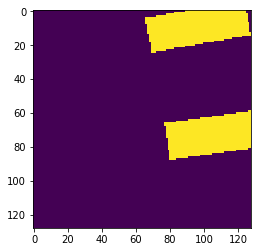

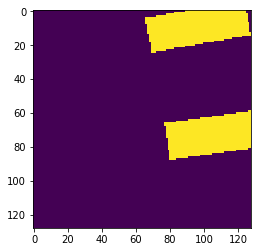

In [3]:
plt.figure()
plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the models', x_train_sim.shape)

In [ ]:
opt1 = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
#opt1 = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#model_ex1 = create_model(opt1, input_shape1)
#model_ex1 = create_model_batch(opt1, input_shape1) # Not good as the skip connection
#model_ex1 = create_model_add_skips(opt1, input_shape1)
#model_ex1 = create_model_add_skips_3(opt1, input_shape1) # Add max pool but not better

#from kmodels import create_model_add_skips_2
#model_ex1 = create_model_add_skips_2(opt1, input_shape1) # ISPRS TCIV
#model_ex1 = create_model_add_skips_linfnorm(opt1, input_shape1)

from mymodels.unet_residual import create_model_residual
model_ex1 = create_model_residual(opt1, input_shape1) # Residual

model_ex1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 6 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 6 128         input_1[0][0]                    
__________________________________________________________________________________________________
activation

/notebooks/tmp/MapGen/mymodels/unet_residual.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  return Model(input=inputs, output=path)


In [ ]:
data_gen_args = dict(rotation_range=180.)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
BATCH_SIZE = 16
result_generator = zip(image_datagen.flow(x_train_sim, batch_size=BATCH_SIZE, seed=seed), 
                       mask_datagen.flow(y_train_sim, batch_size=BATCH_SIZE, seed=seed))

History1 = History()
hist1 = model_ex1.fit_generator(  result_generator,
                                  epochs = 100,
                                  steps_per_epoch=2000,
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[History1, 
                                             EarlyStopping(patience=5), 
                                             ReduceLROnPlateau(patience = 3, verbose = 0),
                                             ModelCheckpoint(outPath + "weights.hdf5", 
                                                             save_best_only = True, 
                                                             save_weights_only = False)],
                                  validation_data=(x_test_sim, y_test_sim))

Epoch 1/100
 730/2000 [=========>....................] - ETA: 5:00 - loss: 0.0088 - acc: 0.9662

## Training

In [ ]:
import os
import numpy as np
import pandas as pd
from data_helper import predict_15k, save_hist, save_model

### Save history
save_hist(History1, outPath)
# Retain best model
#from keras import models
#model_ex1 = models.load_model(outPath + "weights.hdf5")

## Independent Test

In [ ]:
testPath = r"../tmp_data/Data/Testing/"

all_records = []

records = predict_15k(outPath, testPath, outPath, 
                      r"FTest1_input_inv.png", r"FTest1_output_inv.png")
all_records.extend(records)

records = predict_15k(outPath, testPath, outPath, 
                      r"FTest2_input_inv.png", r"FTest2_output_inv.png")
all_records.extend(records)

df = pd.DataFrame(np.transpose(all_records))
df.columns = ["Input vs Target (Test1)", "Prediction vs Target (Test1)", 
              "Input vs Target (Test2)", "Prediction vs Target (Test2)"]

df = df.rename({0: "Accuracy", 1: 'IoU'})
df.index.name = 'Metrics'
df